In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/soict2023-ocr/dataset/Handwritten OCR-20230818T125331Z-001.zip"
!unzip "/content/Handwritten OCR/training_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: new_train/train_img_95500.png  
  inflating: new_train/train_img_95501.png  
  inflating: new_train/train_img_95502.png  
  inflating: new_train/train_img_95503.png  
  inflating: new_train/train_img_95504.png  
  inflating: new_train/train_img_95505.png  
  inflating: new_train/train_img_95506.png  
  inflating: new_train/train_img_95507.png  
  inflating: new_train/train_img_95508.png  
  inflating: new_train/train_img_95509.png  
  inflating: new_train/train_img_9551.jpg  
  inflating: new_train/train_img_95510.png  
  inflating: new_train/train_img_95511.png  
  inflating: new_train/train_img_95512.png  
  inflating: new_train/train_img_95513.png  
  inflating: new_train/train_img_95514.png  
  inflating: new_train/train_img_95515.png  
  inflating: new_train/train_img_95516.png  
 extracting: new_train/train_img_95517.png  
  inflating: new_train/train_img_95518.png  
  inflating: new_train/train_img_95519.png  
  inf

In [3]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
import math
from PIL import Image
import warnings

np.random.seed(42)

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import StringLookup
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

In [4]:
data = []
with open("/content/Handwritten OCR/train_gt.txt") as file:
    data = [line.split() for line in file]

train_raw = pd.DataFrame(data, columns=["file_path", "label"])
train_raw["file_path"] = "/content/new_train/" + train_raw["file_path"]
train_raw.head()

,file_path,label
0,/content/new_train/train_img_0.jpg,Thỗn
1,/content/new_train/train_img_1.jpg,May-So
2,/content/new_train/train_img_2.jpg,nhẹn
3,/content/new_train/train_img_3.jpg,hàu
4,/content/new_train/train_img_4.jpg,Quấy


In [5]:
if not os.path.exists("/content/drive/MyDrive/soict2023-ocr/alphabets.txt"):
    with open("/content/drive/MyDrive/soict2023-ocr/alphabets.txt", "w", encoding="utf-8") as f_write:
        alphabets = "".join(sorted(list(set("".join(train_raw["label"].to_list())))))
        f_write.write(alphabets)

with open("/content/drive/MyDrive/soict2023-ocr/alphabets.txt", "r", encoding="utf-8") as f_read:
    alphabets = f_read.readline()
print(alphabets)

-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ


In [6]:
def split_data(df:pd.DataFrame, train_size=0.9, shuffle=True):
    size = df.shape[0]
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)

    train_df = df.iloc[indices[:train_samples]]
    val_df = df.iloc[indices[train_samples:]]
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True)

train_df, valid_df = split_data(train_raw, train_size=0.9, shuffle=True)
train_size = train_df.shape[0]
valid_size = valid_df.shape[0]

print(f"Train with {train_size} images and validate with {valid_size} images")

Train with 92700 images and validate with 10300 images


In [7]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(alphabets), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [22]:
image_width = 256
image_height = 64

max_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

batch_size = 64
padding_token = 999

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

In [23]:
class OCRDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_frame, batch_size=10):
        self.data_frame = data_frame
        self.train_len = len(data_frame)
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.train_len/self.batch_size)

    def __get_image(self, file_id):
        img = preprocess_image(file_id)
        return img

    def __get_label(self, label_id):
        label = vectorize_label(label_id)
        return label

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, self.train_len)

        batch_x = self.data_frame["file_path"][low:high]
        batch_y = self.data_frame["label"][low:high]

        x = [self.__get_image(file_id) for file_id in batch_x]
        y = [self.__get_label(label_id) for label_id in batch_y]

        inputs = np.array(x)
        targets = np.array(y)
        return [inputs, targets], targets

In [24]:
train_ds = OCRDataGenerator(train_df, batch_size=128)
validation_ds = OCRDataGenerator(valid_df, batch_size=128)

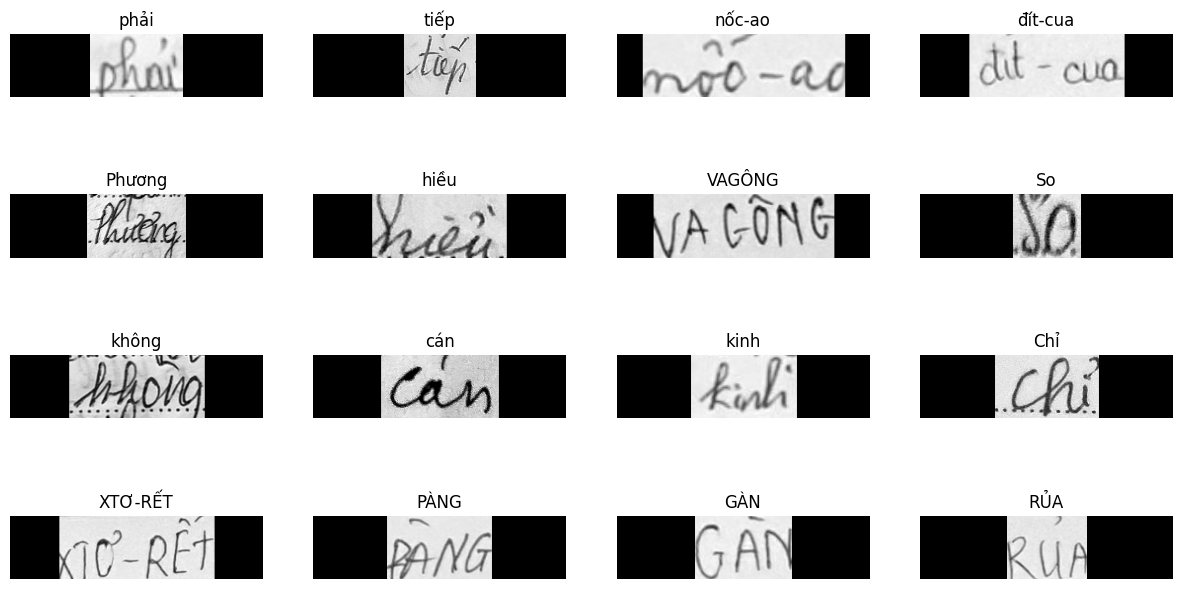

In [25]:
[images, labels], dummy = train_ds[0]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    # Gather indices where label!= padding_token.
    label = labels[i]
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
    # Convert to string.
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")



plt.show()

In [26]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [27]:
def build_model():
    # Inputs to the model
    input_img = tf.keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

   # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_img)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((64, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(inner)
    inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25))(inner)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(inner)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 256, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 64, 64)  640         ['image[0][0]']                  
                                                                                                  
 batch_normalization_35 (BatchN  (None, 256, 64, 64)  256        ['conv1[0][0]']                  
 ormalization)                                                                                    
                                                                             

In [28]:
validation_images = []
validation_labels = []

for [image, label], dummy in validation_ds:
    validation_images.append(image)
    validation_labels.append(label)

In [29]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = K.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose=0)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [45]:
pretrained_path = '/content/drive/MyDrive/crnn_weights.h5'
model = build_model()
if os.path.exists(pretrained_path):
    model.load_weights(pretrained_path)

prediction_model = tf.keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/checkpoint_crnn_weights.h5',
    save_weights_only=True,
    save_best_only=True,
    save_freq='epoch')

In [ ]:
epochs = 2

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, model_checkpoint_callback],
)

Epoch 1/2
156/725 [=====>........................] - ETA: 20:35 - loss: 0.6943

In [44]:
model.save_weights('/content/drive/MyDrive/crnn_weights.h5')

4/4 [==============================] - 0s 53ms/step


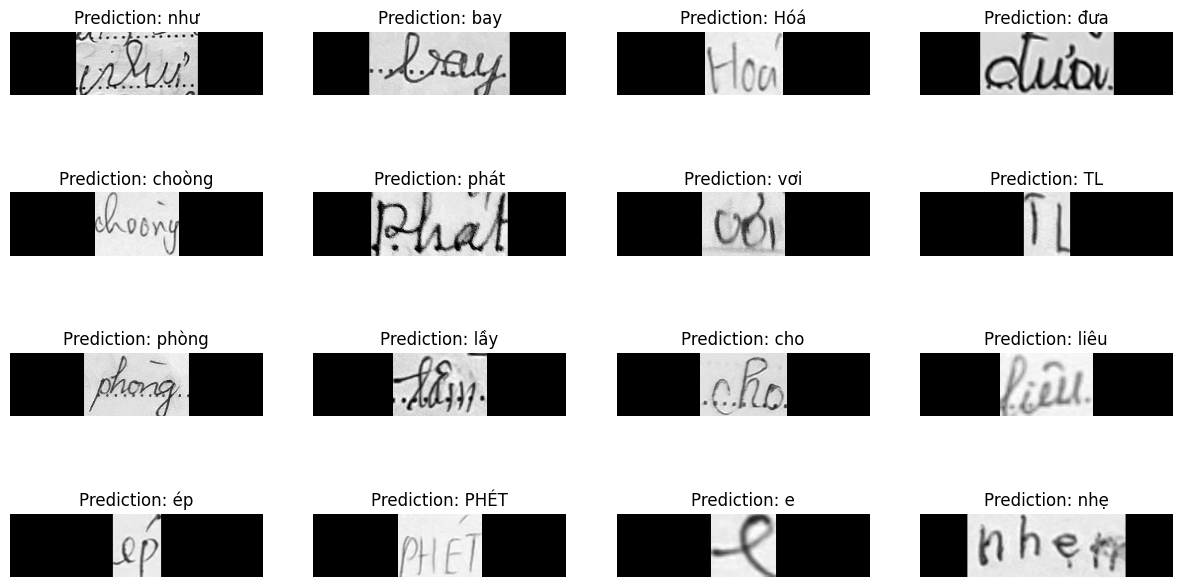

In [41]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = K.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
[images, labels], dummy = validation_ds[0]
_, ax = plt.subplots(4, 4, figsize=(15, 8))

preds = prediction_model.predict(images)
pred_texts = decode_batch_predictions(preds)

for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")

plt.show()